In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("preprocessing.csv", parse_dates=["date"])


In [2]:
df.head()

,item_id,date,hs4,value,weight,quantity,has_tx,value_missing,value_zero,weight_missing,weight_zero,quantity_missing,quantity_zero,year,month
0,AANGBULD,2022-01-01,4810.0,14276.0,17625.0,0.0,1,0,0,0,0,0,1,2022,1
1,AANGBULD,2022-02-01,4810.0,52347.0,67983.0,0.0,1,0,0,0,0,0,1,2022,2
2,AANGBULD,2022-03-01,4810.0,53549.0,69544.0,0.0,1,0,0,0,0,0,1,2022,3
3,AANGBULD,2022-04-01,NaN,0.0,0.0,0.0,0,0,0,0,0,0,0,2022,4
4,AANGBULD,2022-05-01,4810.0,26997.0,34173.0,0.0,1,0,0,0,0,0,1,2022,5


In [3]:
#df['value'].describe()
#df.loc[df['value'] == 0]
df.groupby("item_id")["value"].describe()

,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
AANGBULD,43.0,8.401770e+04,1.452850e+05,0.0,0.0,26507.0,52948.0,533478.0
AHMDUILJ,43.0,1.268288e+05,4.605015e+04,29231.0,89385.5,126401.0,151083.5,242705.0
ANWUJOKX,43.0,8.146721e+03,2.058704e+04,0.0,0.0,0.0,0.0,81670.0
APQGTRMF,43.0,2.572081e+05,2.120713e+05,0.0,102552.0,205326.0,397112.5,759980.0
ATLDMDBO,43.0,5.999737e+07,3.273012e+07,25450412.0,33033815.5,50663797.0,73168303.0,146216818.0
...,...,...,...,...,...,...,...,...
YSYHGLQK,43.0,2.228791e+03,2.608516e+03,0.0,553.0,1108.0,2997.0,10651.0
ZCELVYQU,43.0,1.986054e+05,2.969204e+05,0.0,11035.0,59900.0,284387.0,1187539.0
ZGJXVMNI,43.0,2.256273e+06,8.538016e+05,1141931.0,1566712.5,1816734.0,3008946.5,4419464.0


In [4]:
df["value_log"] = np.log1p(df["value"])

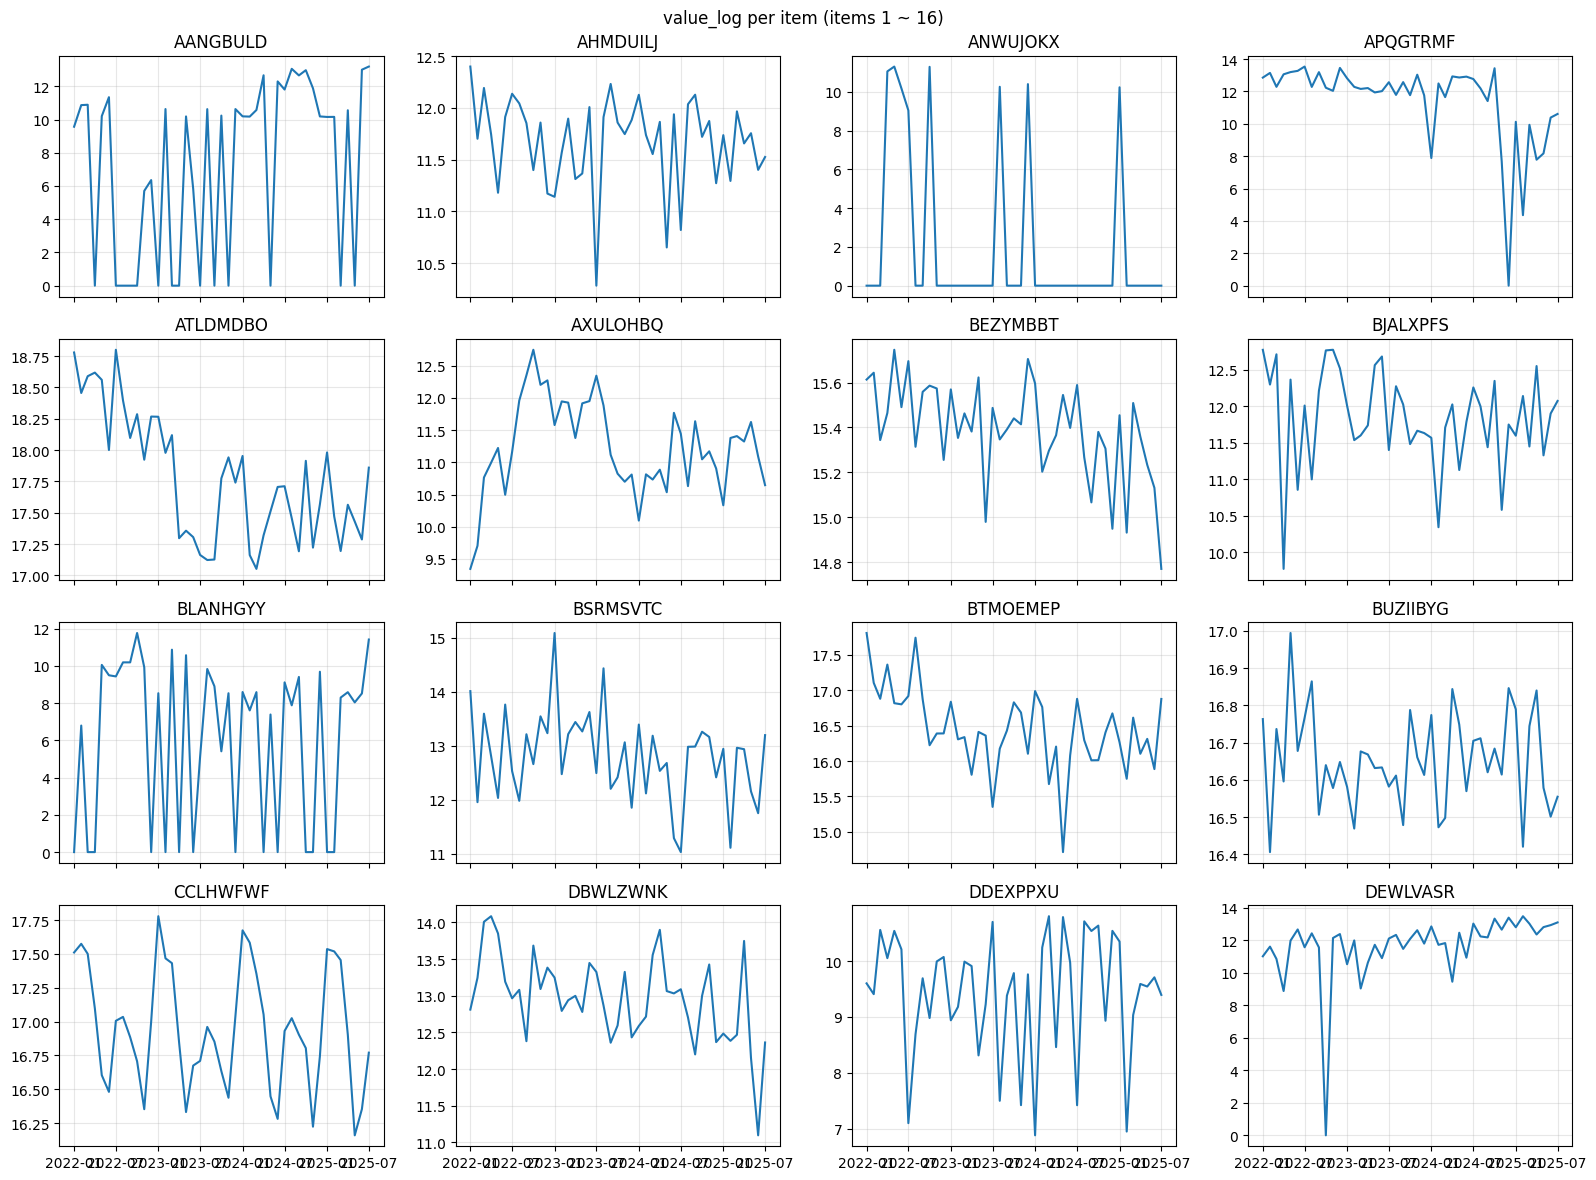

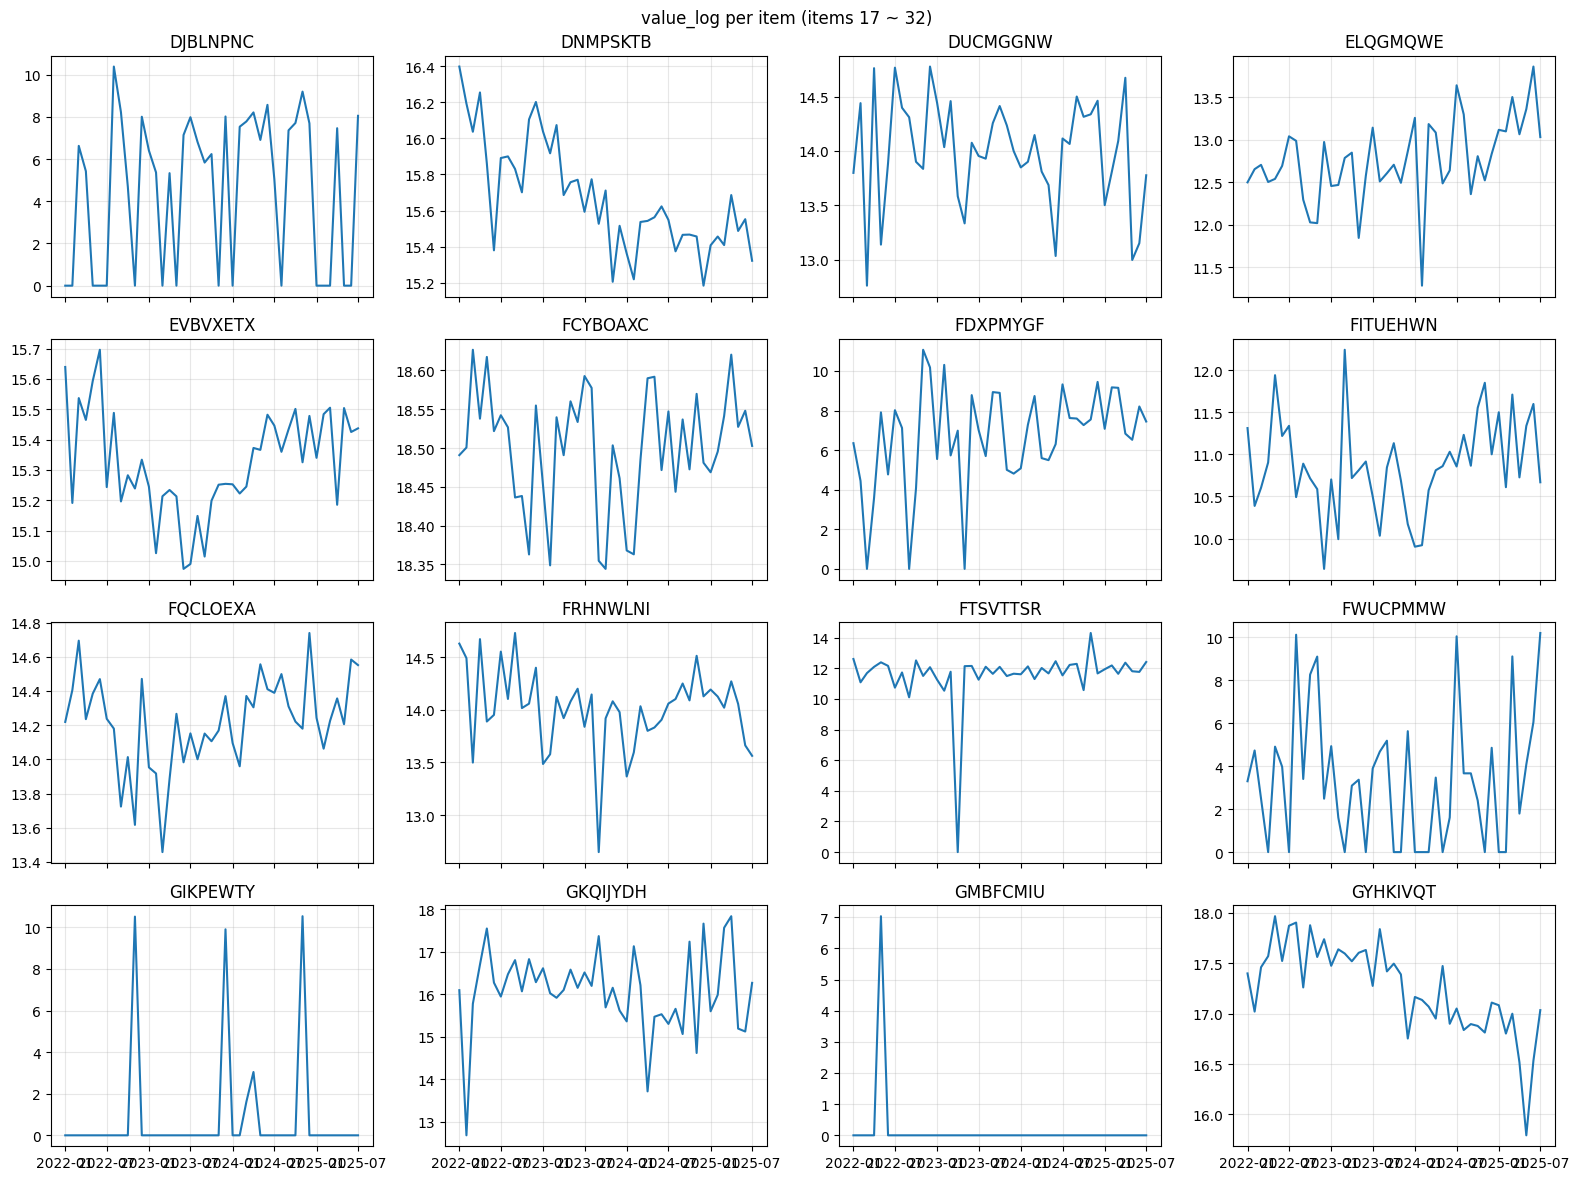

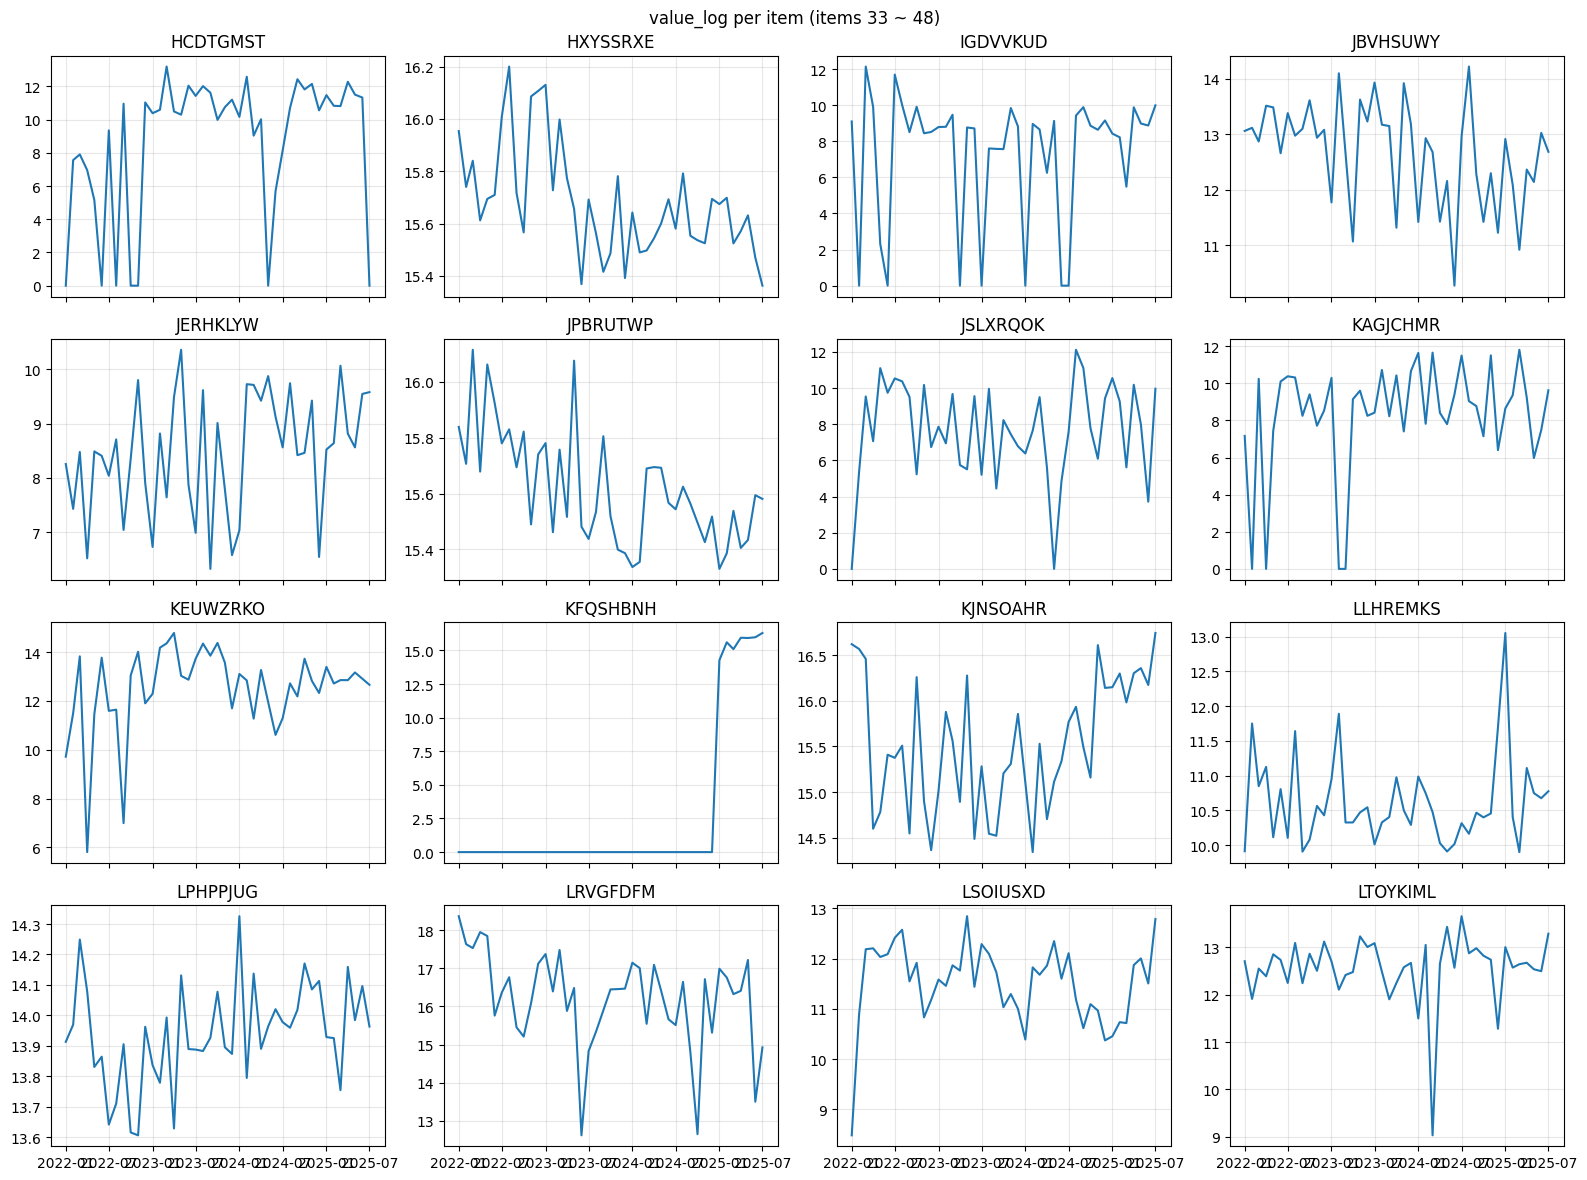

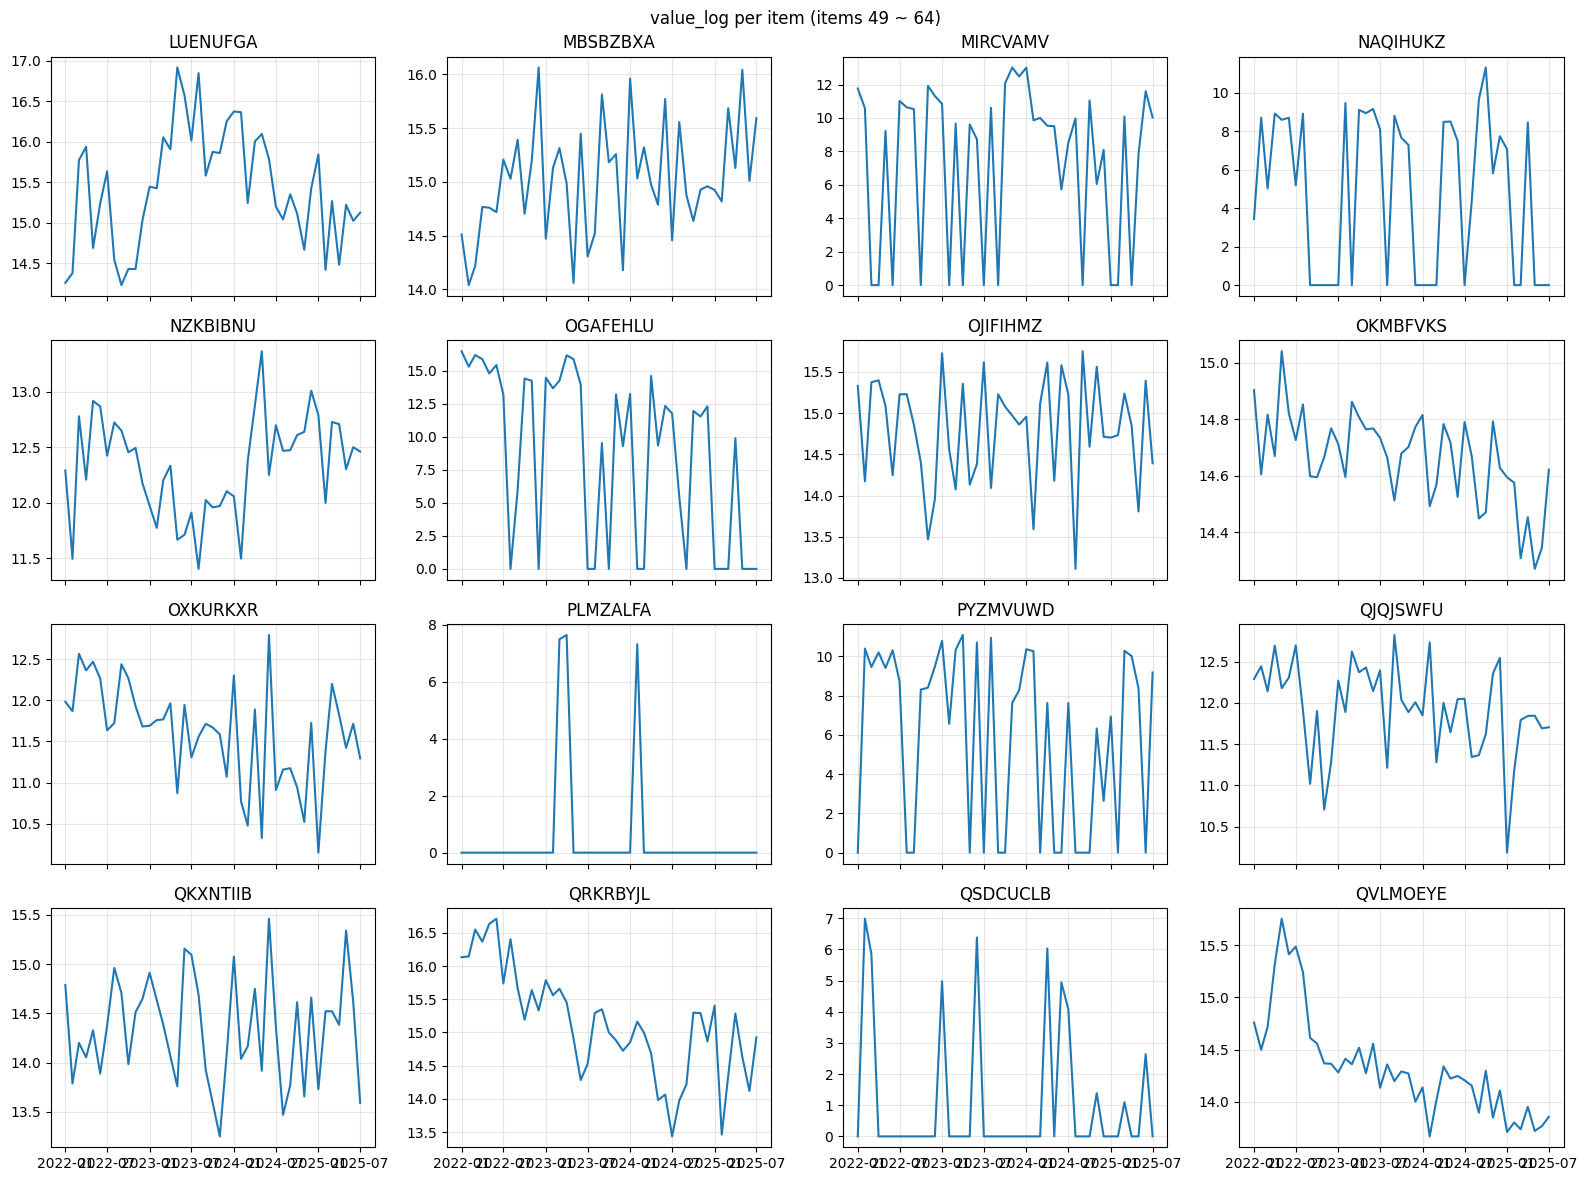

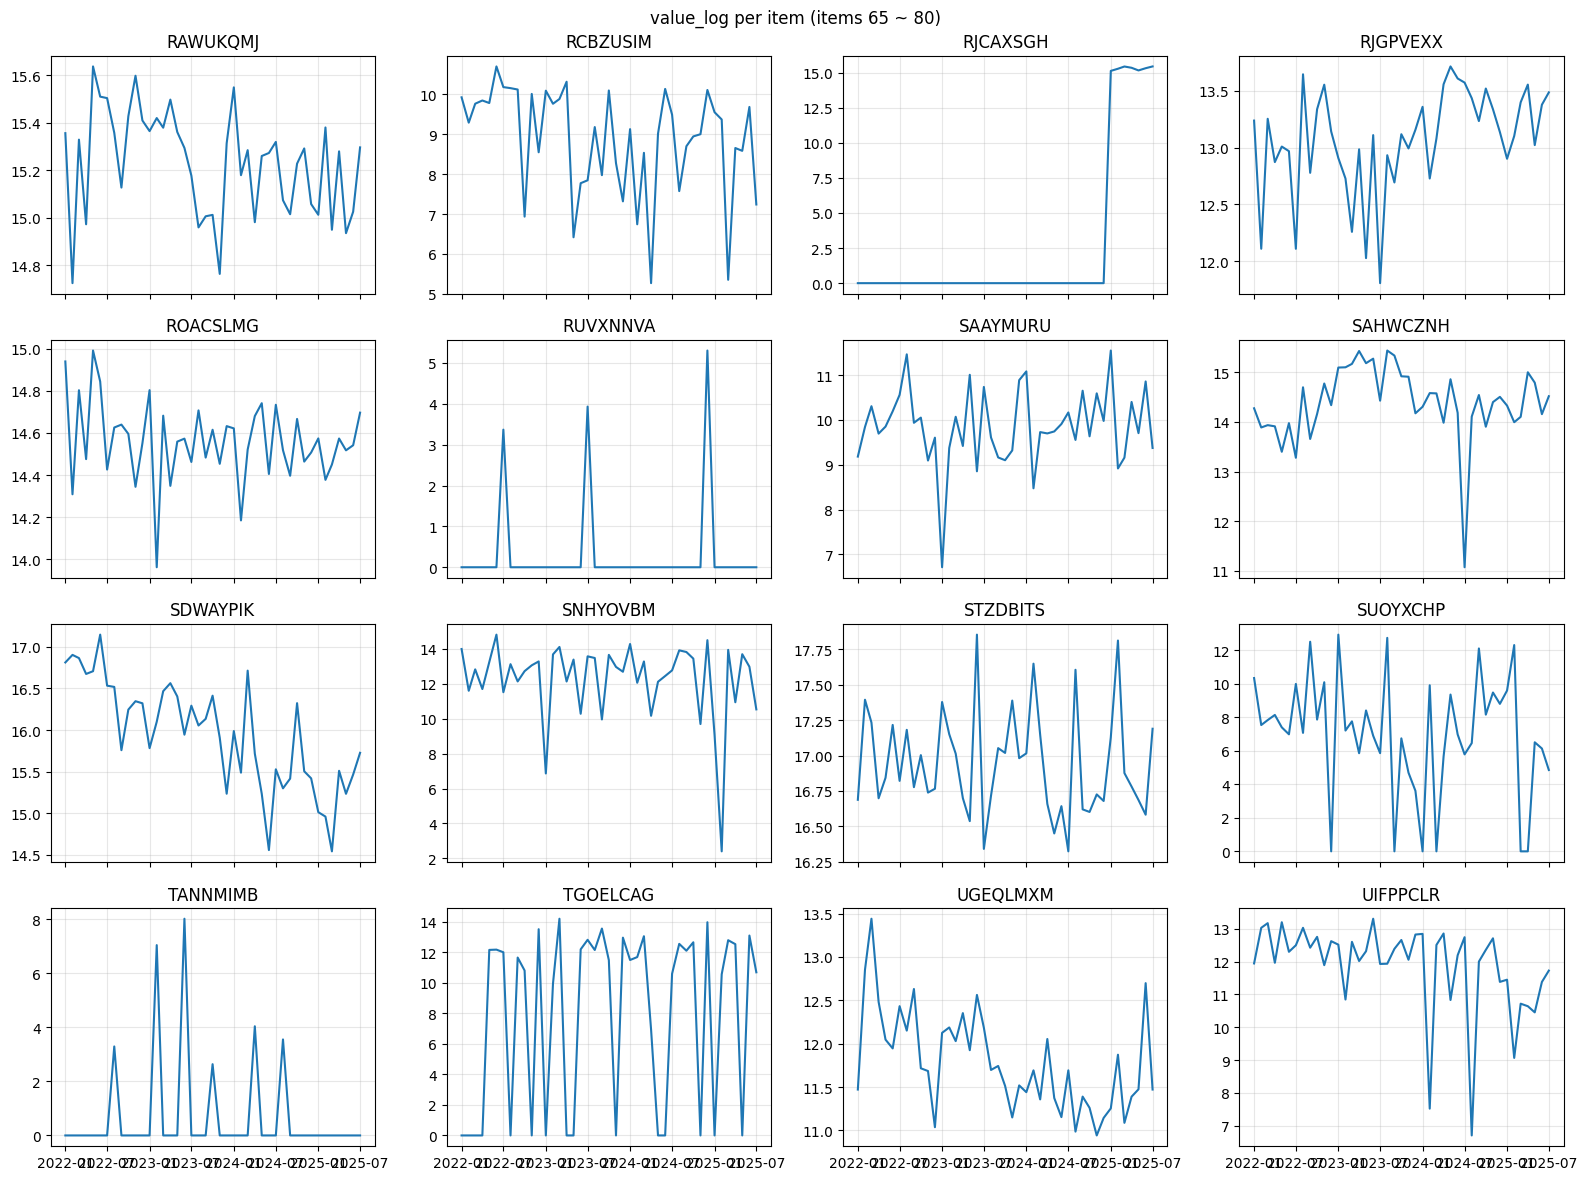

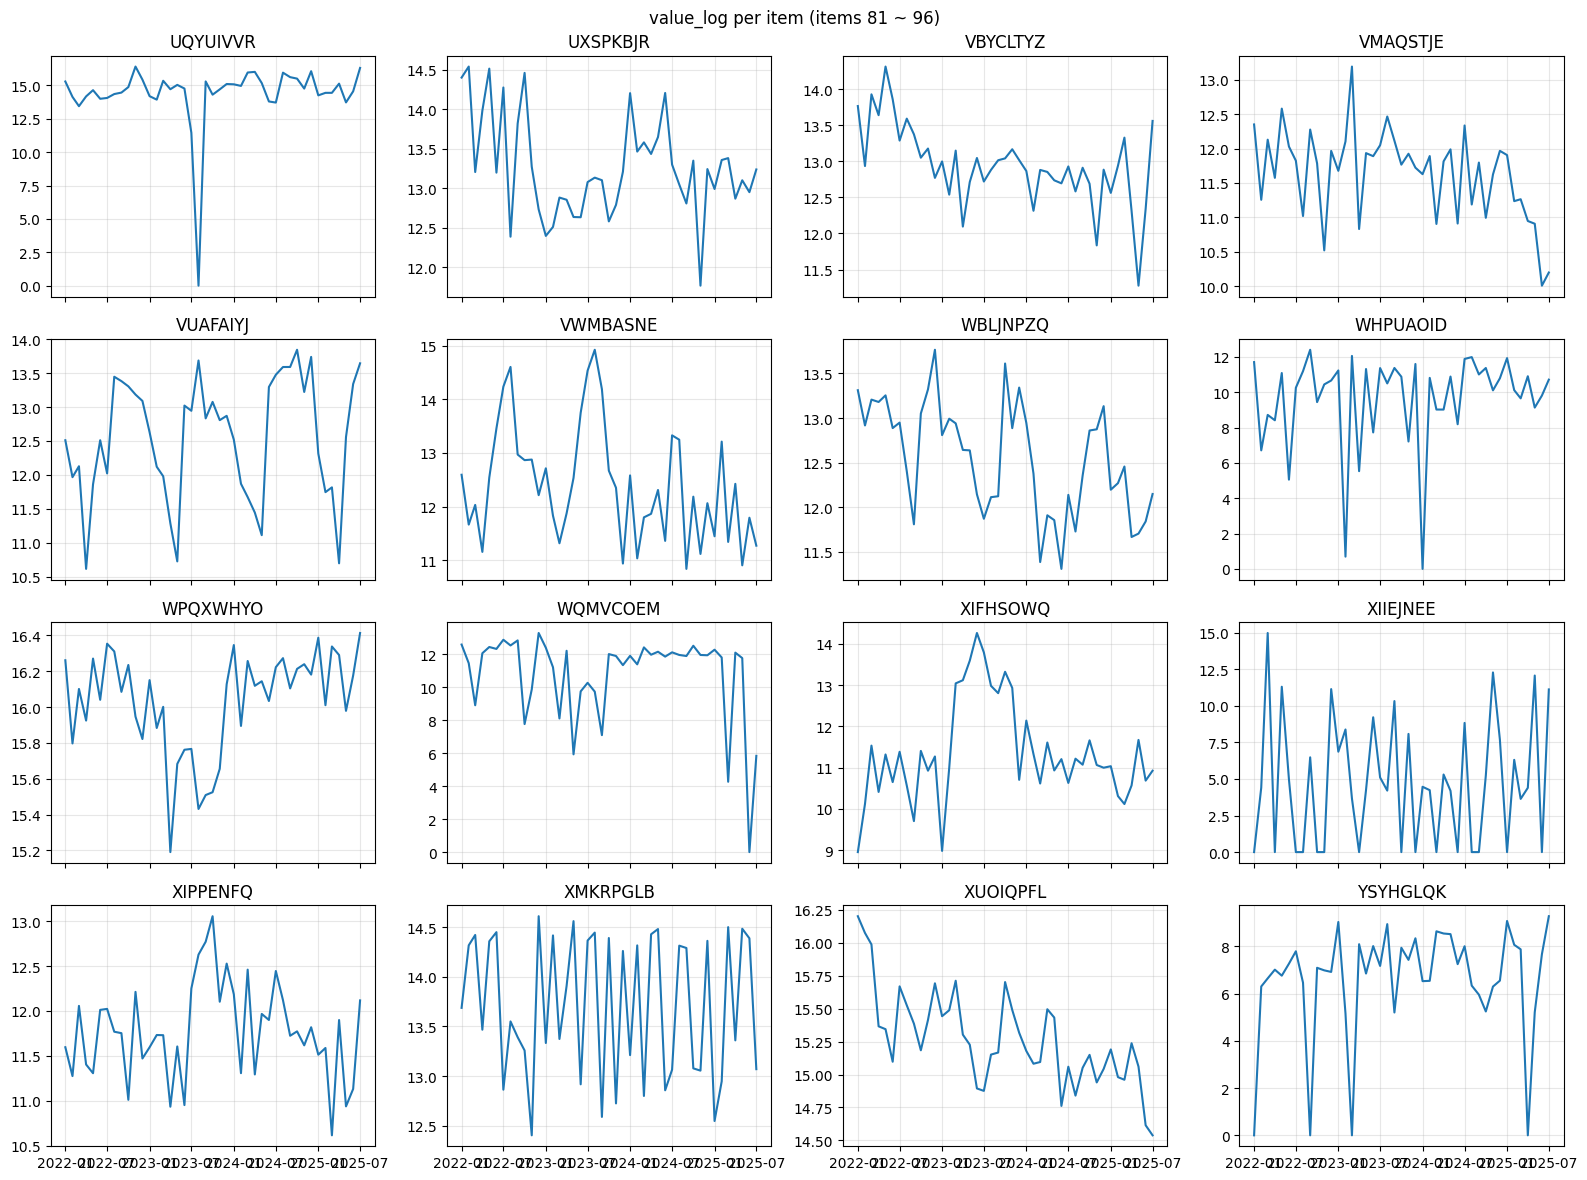

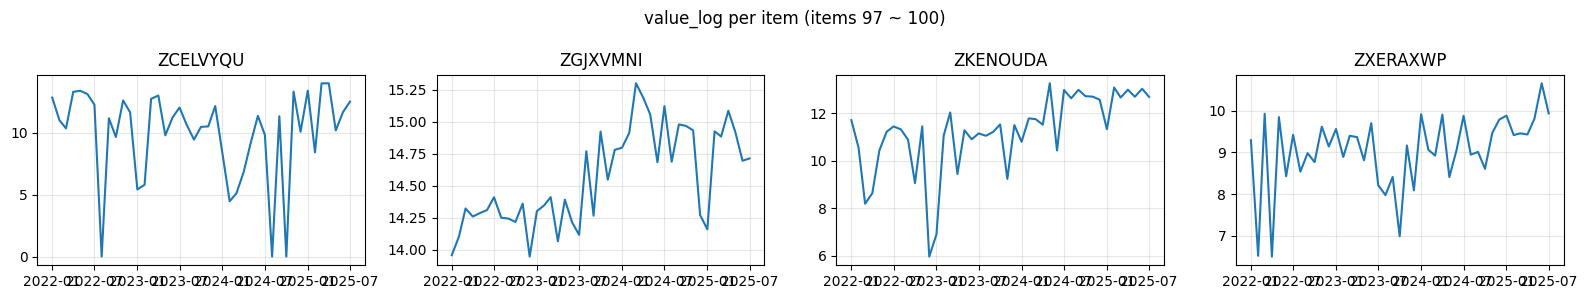

In [5]:
#1-1. item별 시계열을 여러 개씩 한 Figure에 깔끔하게 그리기
import matplotlib.pyplot as plt
import numpy as np

def plot_items_timeseries(
    df,
    value_col="value_log",      # "value_z", "value_minmax", "value_log1p", "value_log1p_diff" 등
    items_per_page=16,
    ncols=4
):
    """
    item_id별 시계열을 여러 개씩 자동으로 그려줌.
    - value_col: 시각화에 사용할 컬럼 이름
    - items_per_page: 한 Figure에 그릴 item 개수
    - ncols: 한 줄에 몇 개 subplot
    """
    unique_items = sorted(df["item_id"].unique())
    total_items = len(unique_items)
    
    for start in range(0, total_items, items_per_page):
        subset_items = unique_items[start:start + items_per_page]
        n = len(subset_items)
        nrows = int(np.ceil(n / ncols))
        
        fig, axes = plt.subplots(
            nrows, ncols,
            figsize=(4 * ncols, 3 * nrows),
            sharex=True
        )
        axes = np.array(axes).reshape(-1)
        
        for ax, item in zip(axes, subset_items):
            d = df[df["item_id"] == item]
            ax.plot(d["date"], d[value_col])
            ax.set_title(str(item))
            ax.grid(alpha=0.3)
        
        # 남는 subplot 제거
        for j in range(len(subset_items), len(axes)):
            fig.delaxes(axes[j])
        
        fig.suptitle(f"{value_col} per item (items {start+1} ~ {start+len(subset_items)})")
        fig.tight_layout()
        plt.show()

# 예시: value_log 기준 패턴 확인
plot_items_timeseries(df, value_col="value_log", items_per_page=16, ncols=4)

# 필요하면 diff 기반 패턴도
# plot_items_timeseries(df_eda, value_col="value_log1p_diff", items_per_page=16, ncols=4)


In [6]:
## 2-1. 아이템별 시계열 행렬 만들기 (item × time)
# 공통 월 인덱스 만들기
all_months = pd.date_range(
    df["date"].min(),
    df["date"].max(),
    freq="MS"  # Month Start
)

# item별로 value_log 시계열을 all_months 기준으로 정렬 & 보간
# 결과: index = all_months, columns = item_id
ts_matrix = (
    df
    .set_index("date")
    .groupby("item_id")["value_log"]
    .apply(lambda s: s.reindex(all_months).interpolate())
    .unstack(0)    # rows: date, cols: item_id
)

print(ts_matrix.shape)  # (num_months, num_items)


(43, 100)


In [7]:
#2-2. KMeans로 clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# item × time 형태로 변환 (KMeans input)
X = ts_matrix.T  # rows: item, cols: time

# 각 time-step feature를 기준으로 표준화 (아이템 간 스케일 차이 제거)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수는 대략 5~10 정도부터 시도
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X_scaled)

cluster_df = pd.DataFrame({
    "item_id": X.index,
    "cluster": labels
})

print(cluster_df.head())
print(cluster_df["cluster"].value_counts())


    item_id  cluster
0  AANGBULD        5
1  AHMDUILJ        2
2  ANWUJOKX        3
3  APQGTRMF        2
4  ATLDMDBO        0
cluster
2    35
0    35
5    16
3    10
1     3
4     1
Name: count, dtype: int64


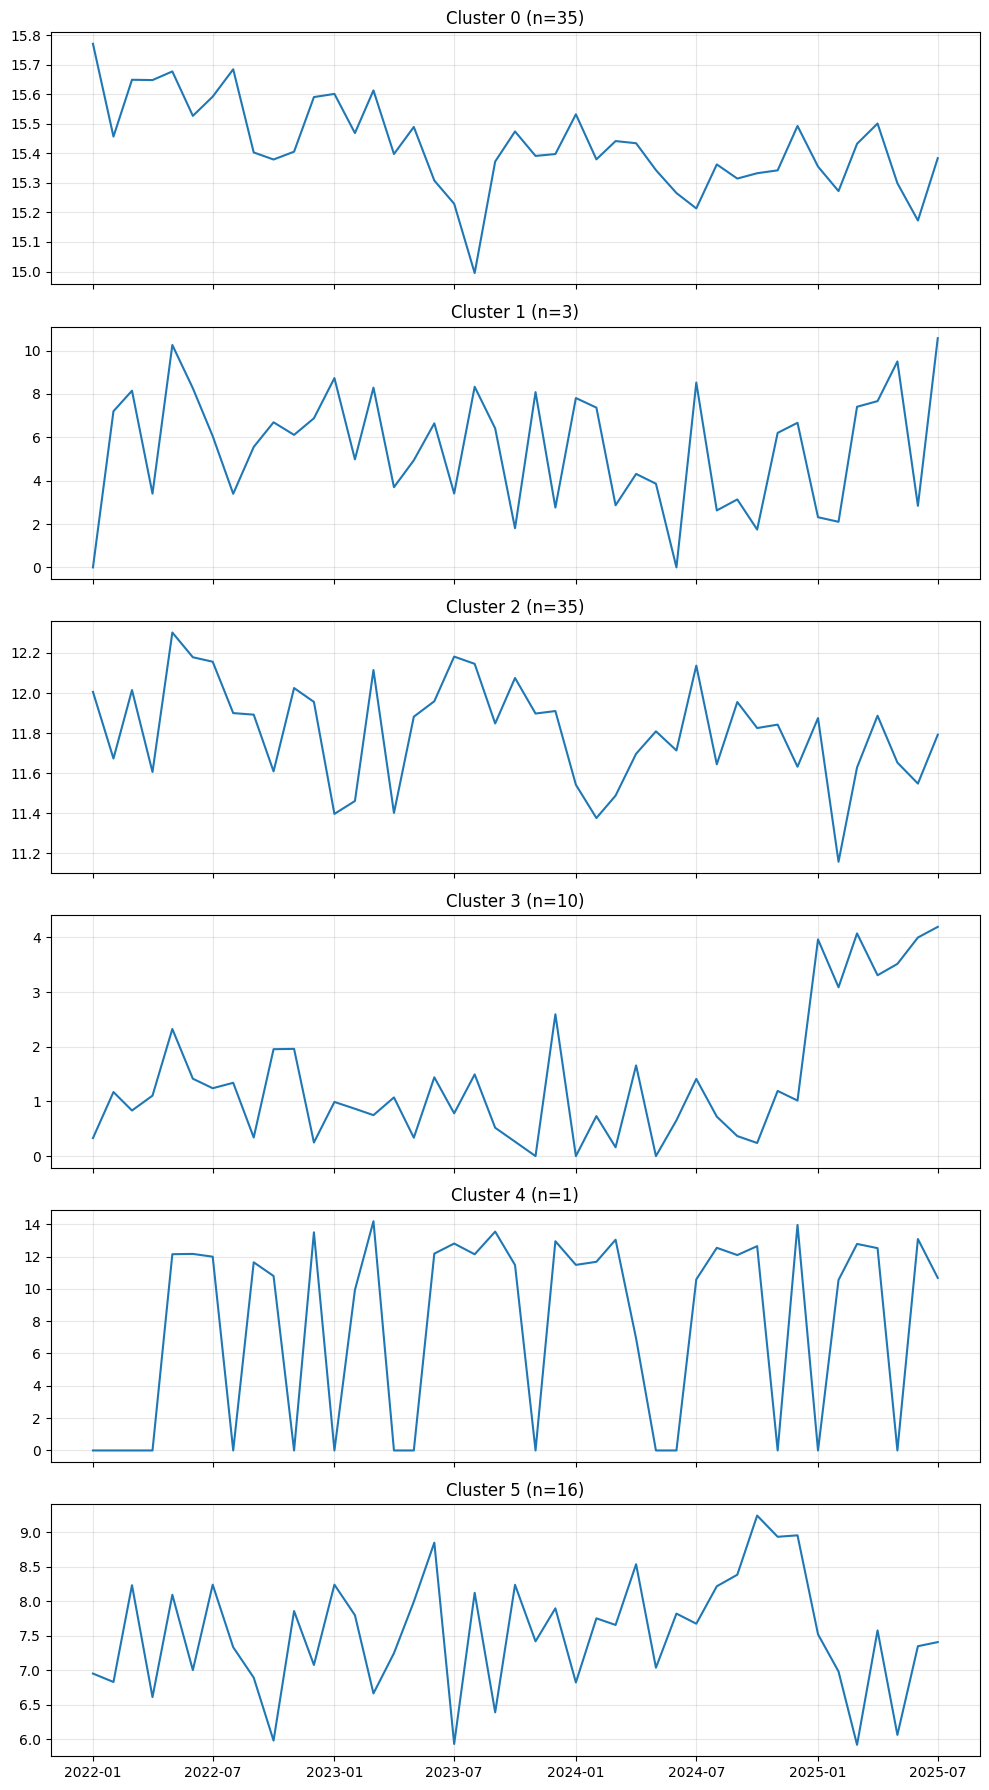

In [8]:
#2-3. 클러스터별 평균 패턴 시각화 (탐색용)
def plot_cluster_centers(ts_matrix, cluster_df, n_clusters):
    """
    클러스터별 평균 시계열 패턴 (log1p 기준)
    """
    fig, axes = plt.subplots(
        n_clusters, 1,
        figsize=(10, 3 * n_clusters),
        sharex=True
    )
    
    if n_clusters == 1:
        axes = [axes]
    
    for c in range(n_clusters):
        ax = axes[c]
        items_in_c = cluster_df[cluster_df["cluster"] == c]["item_id"]
        if len(items_in_c) == 0:
            ax.set_title(f"Cluster {c} (no items)")
            continue
        
        # cluster에 속한 item들의 시계열 평균
        mean_series = ts_matrix[items_in_c].mean(axis=1)
        ax.plot(ts_matrix.index, mean_series)
        ax.set_title(f"Cluster {c} (n={len(items_in_c)})")
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_cluster_centers(ts_matrix, cluster_df, n_clusters)


In [9]:
def find_comovement_pairs(
    ts_matrix,
    max_lag=6,       # 최대 6개월까지 선후행 탐지
    min_corr=0.7,    # 최소 상관계수 절댓값
    min_common=6     # 공통 관측 개수 최소
):
    """
    ts_matrix: index = date, columns = item_id, values = 연속형 (log1p 등)
    
    return: DataFrame
      [leading_item_id, following_item_id, lead_lag, corr, corr_sign]
    """
    # 컬럼 이름들 (item_id)
    items = ts_matrix.columns.tolist()
    n_items = len(items)
    
    results = []
    
    # 결측이 많은 경우를 대비해, 미리 각 item별로 z-score (패턴 위주)
    def _zscore(col: pd.Series) -> pd.Series:
        std = col.std()
        if std is None or np.isnan(std) or std == 0:
            return col - col.mean()
        return (col - col.mean()) / std

    ts_std = ts_matrix.apply(_zscore, axis=0)
    
    for i in range(n_items):
        for j in range(i + 1, n_items):
            a_name = items[i]
            b_name = items[j]
            
            a = ts_std[a_name]
            b = ts_std[b_name]
            
            # 둘 다 NaN인 구간 제거
            ab = pd.concat([a, b], axis=1).dropna()
            if len(ab) < min_common:
                continue
            
            a_clean = ab.iloc[:, 0]
            b_clean = ab.iloc[:, 1]
            
            best_corr = 0.0
            best_lag = 0
            
            # -max_lag ~ +max_lag 범위 탐색
            for lag in range(-max_lag, max_lag + 1):
                if lag == 0:
                    corr = a_clean.corr(b_clean)
                elif lag > 0:
                    # A_t vs B_{t+lag} → A가 선행, B가 후행
                    corr = a_clean.iloc[:-lag].corr(b_clean.iloc[lag:])
                else:  # lag < 0
                    k = -lag
                    # A_{t+k} vs B_t → B가 선행, A가 후행
                    corr = a_clean.iloc[k:].corr(b_clean.iloc[:-k])
                
                if corr is None or np.isnan(corr):
                    continue
                
                if abs(corr) > abs(best_corr):
                    best_corr = corr
                    best_lag = lag
            
            # 조건을 만족하는 쌍만 저장
            if abs(best_corr) >= min_corr and best_lag != 0:
                if best_lag > 0:
                    # A_t -> B_{t+lag}
                    leading = a_name
                    following = b_name
                    lead_lag = best_lag
                else:
                    # lag < 0 → B_t -> A_{t-k}
                    leading = b_name
                    following = a_name
                    lead_lag = -best_lag  # 양수로 변환
                
                results.append({
                    "leading_item_id": leading,
                    "following_item_id": following,
                    "lead_lag_months": lead_lag,
                    "corr": best_corr,
                    "corr_abs": abs(best_corr),
                    "corr_sign": "positive" if best_corr > 0 else "negative"
                })
    
    if not results:
        return pd.DataFrame(columns=[
            "leading_item_id", "following_item_id",
            "lead_lag_months", "corr", "corr_abs", "corr_sign"
        ])
    
    result_df = pd.DataFrame(results)
    result_df = result_df.sort_values(
        ["corr_abs", "lead_lag_months"],
        ascending=[False, True]
    ).reset_index(drop=True)
    
    return result_df

comovement_candidates = find_comovement_pairs(
    ts_matrix=ts_matrix,
    max_lag=6,
    min_corr=0.7,
    min_common=6
)

print(f"발견된 공행성 쌍 개수: {len(comovement_candidates)}")
print(comovement_candidates.head(20))

# 만약 쌍이 너무 적으면 threshold를 낮춰보기
if len(comovement_candidates) < 10:
    print("\n⚠️ 공행성 쌍이 너무 적습니다. threshold를 낮춰서 다시 시도합니다...")
    comovement_candidates = find_comovement_pairs(
        ts_matrix=ts_matrix,
        max_lag=6,
        min_corr=0.5,  # 0.7 -> 0.5로 낮춤
        min_common=6
    )
    print(f"낮춘 threshold로 발견된 공행성 쌍 개수: {len(comovement_candidates)}")


/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/admin/Desktop/hazel/Data/com

발견된 공행성 쌍 개수: 3
  leading_item_id following_item_id  lead_lag_months      corr  corr_abs  \
0        RJCAXSGH          KFQSHBNH                6  1.000000  1.000000   
1        VBYCLTYZ          QVLMOEYE                3  0.716040  0.716040   
2        QVLMOEYE          GYHKIVQT                4  0.700747  0.700747   

  corr_sign  
0  positive  
1  positive  
2  positive  

⚠️ 공행성 쌍이 너무 적습니다. threshold를 낮춰서 다시 시도합니다...


/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/admin/Desktop/hazel/Data/com

낮춘 threshold로 발견된 공행성 쌍 개수: 107


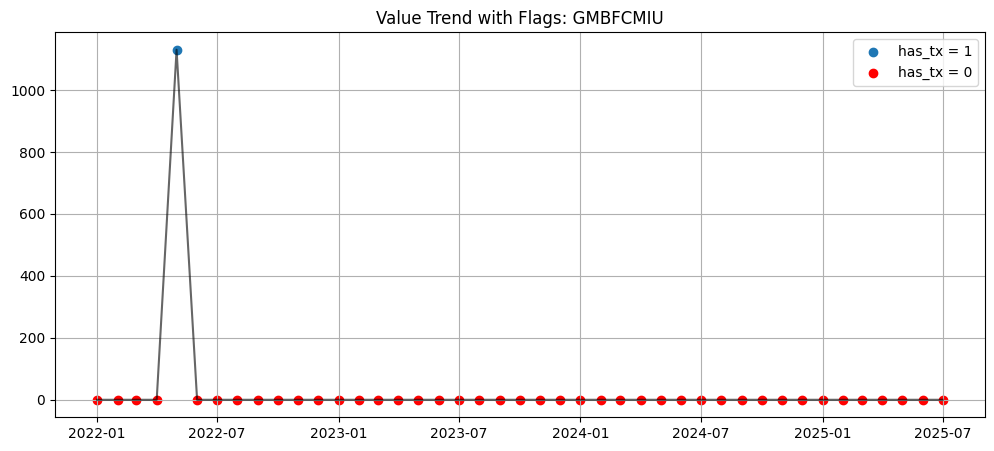

In [10]:
import matplotlib.pyplot as plt

item = "GMBFCMIU"
d = df[df["item_id"] == item].sort_values("date")

plt.figure(figsize=(12, 5))
plt.plot(d["date"], d["value"], color="black", alpha=0.6)

# 정상 데이터
normal = d[d["has_tx"] == 1]
plt.scatter(normal["date"], normal["value"], label="has_tx = 1")

# 거래 없음
missing = d[d["has_tx"] == 0]
plt.scatter(missing["date"], missing["value"], color="red", label="has_tx = 0")

plt.title(f"Value Trend with Flags: {item}")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def build_pair_training_data(
    df_panel,
    comovement_candidates,
    max_lag=6,
    predict_horizon=1
):
    """
    df_panel: make_model_panel 결과 (raw 기반)
    comovement_candidates: 공행성 후보쌍 DataFrame
        [leading_item_id, following_item_id, lead_lag_months, corr, ...]
    max_lag: 생성되어 있는 lag 개수
    predict_horizon: 몇 달 뒤 value를 예측할지 (기본 1개월 뒤)
    """
    # item별로 미리 나눠두면 반복에서 빠름
    item_groups = {
        item: g.sort_values("date").reset_index(drop=True)
        for item, g in df_panel.groupby("item_id")
    }
    
    pair_dfs = []
    
    # 각 공행 후보쌍에 대해 데이터 생성
    for row in comovement_candidates.itertuples(index=False):
        leading = row.leading_item_id
        following = row.following_item_id
        lead_lag_months = row.lead_lag_months
        corr = row.corr
        
        if leading not in item_groups or following not in item_groups:
            continue
        
        lead_df = item_groups[leading].copy()
        foll_df = item_groups[following].copy()
        
        # ---- 후행 아이템 쪽: feature + target 생성 ----
        # lag feature 생성 (과거 k개월 전 value)
        for k in range(1, max_lag + 1):
            foll_df[f"value_lag_{k}"] = foll_df["value"].shift(k)
        
        # target: 다음 달 value (predict_horizon 만큼 미래)
        foll_df["target_value_next"] = foll_df["value"].shift(-predict_horizon)
        
        # 관측 시점의 feature만 남기기 (id, date 포함)
        foll_lag_cols = [f"value_lag_{k}" for k in range(1, max_lag + 1)]
        foll_feat_cols = (
            ["item_id", "date", "value", "year", "month", "has_tx"]
            + foll_lag_cols
        )
        foll_feat_cols = [c for c in foll_feat_cols if c in foll_df.columns]
        foll_used = foll_df[foll_feat_cols + ["target_value_next"]].copy()
        
        # 컬럼 prefix 붙이기 (following_)
        rename_foll = {
            c: f"f_{c}" for c in foll_used.columns
            if c not in ["date"]  # date는 공통 key로 유지
        }
        foll_used = foll_used.rename(columns=rename_foll)
        
        # ---- 리딩 아이템 쪽: feature만 사용 ----
        # lag feature 생성 (과거 k개월 전 value)
        for k in range(1, max_lag + 1):
            lead_df[f"value_lag_{k}"] = lead_df["value"].shift(k)
        
        lead_lag_cols = [f"value_lag_{k}" for k in range(1, max_lag + 1)]
        lead_feat_cols = ["item_id", "date", "value"] + lead_lag_cols
        lead_feat_cols = [c for c in lead_feat_cols if c in lead_df.columns]
        
        lead_used = lead_df[lead_feat_cols].copy()
        rename_lead = {
            c: f"l_{c}" for c in lead_used.columns
            if c not in ["date"]  # date는 공통 key
        }
        lead_used = lead_used.rename(columns=rename_lead)
        
        # ---- 같은 date 기준으로 merge ----
        merged = pd.merge(
            foll_used,
            lead_used,
            on="date",
            how="inner"
        )
        
        # target / lag 값 없는 행 제거
        feature_cols = [
            c for c in merged.columns
            if c.startswith("f_value_lag_") or c.startswith("l_value_lag_")
        ]
        feature_cols += ["f_value"]  # 현재값도 쓸 수 있음
        
        merged = merged.dropna(subset=feature_cols + ["f_target_value_next"])
        
        # 메타 정보(쌍 정보) 붙이기
        merged["leading_item_id"] = leading
        merged["following_item_id"] = following
        merged["lead_lag_months"] = lead_lag_months
        merged["pair_corr"] = corr
        
        pair_dfs.append(merged)
    
    if not pair_dfs:
        return pd.DataFrame()
    
    train_df = pd.concat(pair_dfs, axis=0, ignore_index=True)
    
    # 편의상 t_idx(시간 index) 추가 (pair별 순번)
    train_df = train_df.sort_values(["following_item_id", "date"])
    train_df["t_idx"] = (
        train_df.groupby(["following_item_id"])
        .cumcount()
        .astype(int)
    )
    
    return train_df

train_df = build_pair_training_data(
    df_panel=df,
    comovement_candidates=comovement_candidates,
    max_lag=6,
    predict_horizon=1
)

print("학습 데이터 shape:", train_df.shape)
print(train_df.head())


학습 데이터 shape: (3852, 26)
     f_item_id       date  f_value  f_year  f_month  f_has_tx  f_value_lag_1  \
792   AANGBULD 2022-07-01      0.0    2022        7         0        84489.0   
1296  AANGBULD 2022-07-01      0.0    2022        7         0        84489.0   
2592  AANGBULD 2022-07-01      0.0    2022        7         0        84489.0   
2808  AANGBULD 2022-07-01      0.0    2022        7         0        84489.0   
3168  AANGBULD 2022-07-01      0.0    2022        7         0        84489.0   

      f_value_lag_2  f_value_lag_3  f_value_lag_4  ...  l_value_lag_2  \
792         26997.0            0.0        53549.0  ...     63497265.0   
1296        26997.0            0.0        53549.0  ...      1603223.0   
2592        26997.0            0.0        53549.0  ...      1015042.0   
2808        26997.0            0.0        53549.0  ...      6942199.0   
3168        26997.0            0.0        53549.0  ...       170541.0   

      l_value_lag_3  l_value_lag_4 l_value_lag_5  l_val

In [12]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# 1) feature / target 분리
target_col = "f_target_value_next"

# 모델에 넣을 feature 후보들
feature_cols = [
    # following lag
    *[f"f_value_lag_{k}" for k in range(1, 6 + 1)],
    # leading lag
    *[f"l_value_lag_{k}" for k in range(1, 6 + 1)],
    # 현재 값, 달 정보, 쌍 메타 정보
    "f_value",
    "lead_lag_months",
    "pair_corr",
    "f_year",
    "f_month",
    "f_has_tx",
]

# 실제로 존재하는 컬럼만 필터링
feature_cols = [c for c in feature_cols if c in train_df.columns]

X = train_df[feature_cols].values
y = train_df[target_col].values

# 2) 간단하게 train/valid 나누기 (시간 기반으로 나눠도 좋고 여기선 랜덤)
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3) RandomForest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
rf_score = rf.score(X_valid, y_valid)
print("RandomForest R^2 on valid:", rf_score)

# 4) GradientBoosting
gbm = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)
gbm.fit(X_train, y_train)
gbm_score = gbm.score(X_valid, y_valid)
print("GradientBoosting R^2 on valid:", gbm_score)

RandomForest R^2 on valid: 0.9741856661262088
GradientBoosting R^2 on valid: 0.9622359167952941


In [13]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet



# ---------------------------------------------------------
# 1) Train / Valid Split
# ---------------------------------------------------------
X = train_df[feature_cols].values
y = train_df["f_target_value_next"].values   # 연속값 (회귀 target)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# ---------------------------------------------------------
# 2) 모델 목록 정의
# ---------------------------------------------------------
models = {
    "RandomForest": RandomForestRegressor(n_estimators=400, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=400, random_state=42),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=400, random_state=42),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "ElasticNet": ElasticNet(alpha=0.001, l1_ratio=0.5),
}


# ---------------------------------------------------------
# 3) 성능 저장용 리스트
# ---------------------------------------------------------
results = []


# ---------------------------------------------------------
# 4) 모델 반복 학습 → NMAE + F1 평가
# ---------------------------------------------------------
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)

    # --- NMAE ---
    mae = mean_absolute_error(y_valid, y_pred)
    nmae = mae / (np.mean(np.abs(y_valid)) + 1e-9)

    # --- F1 Score ---
    # Threshold 기준은 필요에 따라 바꿀 수 있음
    threshold = np.median(y_valid)  
    y_true_cls = (y_valid > threshold).astype(int)
    y_pred_cls = (y_pred > threshold).astype(int)
    f1 = f1_score(y_true_cls, y_pred_cls)

    results.append([name, nmae, f1])


# ---------------------------------------------------------
# 5) 테이블 정리
# ---------------------------------------------------------
results_df = pd.DataFrame(results, columns=["Model", "NMAE", "F1"])
results_df = results_df.sort_values(by=["F1"], ascending=False).reset_index(drop=True)

print(results_df)


              Model      NMAE        F1
0      RandomForest  0.068803  0.978177
1        ExtraTrees  0.055585  0.976923
2  GradientBoosting  0.085488  0.968586
3             Ridge  0.258486  0.945545
4             Lasso  0.258496  0.945545
5        ElasticNet  0.258480  0.945545


/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=3.56613e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.179e+16, tolerance: 7.254e+13
  model = cd_fast.enet_coordinate_descent(
/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.267e+16, tolerance: 7.254e+13
  model = cd_fast.enet_coordinat

In [14]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor

# 1) 회귀 타깃과 피처 준비
#   - f_target_value_next: following item의 "다음 달 value" (너가 만든 타깃 컬럼명)
#   - feature_cols: 아까 모델 비교할 때 썼던 피처 리스트 그대로 사용
y_all = train_df["f_target_value_next"].values
X_all = train_df[feature_cols].values

# 2) 베스트 모델(ExtraTrees)로 전체 학습
best_model = ExtraTreesRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_all, y_all)

,n_estimators,400
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [15]:
import pandas as pd
import numpy as np

PIVOT_DATE = pd.Timestamp("2025-07-01")   # 이 날짜 기준으로 2025-08 예측

def make_inference_features(df_panel, comovement_candidates, max_lag=12):
    """
    2025-07 기준으로 (leading, following) 쌍의 예측용 피처 1row씩 생성
    df_panel: preprocessing 결과 (item_id, date, value 포함, lag는 없음)
    comovement_candidates: leading_item_id, following_item_id 컬럼 포함된 DF
    """
    df_panel = df_panel.copy()
    df_panel["date"] = pd.to_datetime(df_panel["date"])
    
    # item별로 시계열 데이터를 정렬해서 저장 (lag 계산용)
    item_series = {}
    for item_id, group in df_panel.groupby("item_id"):
        item_series[item_id] = group.sort_values("date").reset_index(drop=True)
    
    # 1) 2025-07 데이터만 필터링
    panel_202507 = df_panel[df_panel["date"] == PIVOT_DATE].copy()
    
    item_map_202507 = {item: g.iloc[0] for item, g in panel_202507.groupby("item_id")}
    
    rows = []
    
    print(f"comovement_candidates 개수: {len(comovement_candidates)}")
    
    for row in comovement_candidates.itertuples(index=False):
        leading = row.leading_item_id
        following = row.following_item_id
        
        # 해당 아이템이 2025-07에 존재하지 않으면 스킵
        if leading not in item_map_202507 or following not in item_map_202507:
            continue
        
        # 해당 아이템의 전체 시계열이 없으면 스킵
        if leading not in item_series or following not in item_series:
            continue
        
        lead_series = item_series[leading]
        foll_series = item_series[following]
        
        # 2025-07 시점의 인덱스 찾기
        lead_idx = lead_series[lead_series["date"] == PIVOT_DATE].index
        foll_idx = foll_series[foll_series["date"] == PIVOT_DATE].index
        
        if len(lead_idx) == 0 or len(foll_idx) == 0:
            continue
        
        lead_idx = lead_idx[0]
        foll_idx = foll_idx[0]
        
        lead_row = item_map_202507[leading]
        foll_row = item_map_202507[following]
        
        data = {
            "leading_item_id": leading,
            "following_item_id": following,
            "date": PIVOT_DATE,
        }
        
        # following 쪽 피처
        data["f_value"] = foll_row["value"]
        data["f_has_tx"] = foll_row.get("has_tx", 0)
        data["f_year"] = foll_row["year"]
        data["f_month"] = foll_row["month"]
        
        # following lag feature 생성 (과거 k개월 전 value)
        for k in range(1, max_lag + 1):
            lag_idx = foll_idx - k
            if lag_idx >= 0:
                data[f"f_value_lag_{k}"] = foll_series.iloc[lag_idx]["value"]
            else:
                data[f"f_value_lag_{k}"] = 0.0  # 과거 데이터가 없으면 0
        
        # leading 쪽 피처
        data["l_value"] = lead_row["value"]
        
        # leading lag feature 생성 (과거 k개월 전 value)
        for k in range(1, max_lag + 1):
            lag_idx = lead_idx - k
            if lag_idx >= 0:
                data[f"l_value_lag_{k}"] = lead_series.iloc[lag_idx]["value"]
            else:
                data[f"l_value_lag_{k}"] = 0.0  # 과거 데이터가 없으면 0
        
        # 공행 후보 정보 추가 (필수!)
        data["lead_lag_months"] = row.lead_lag_months
        data["pair_corr"] = row.corr
        
        rows.append(data)
    
    if not rows:
        return pd.DataFrame()
    
    infer_df = pd.DataFrame(rows)
    print(f"생성된 추론 데이터 개수: {len(infer_df)}")
    return infer_df

# 예시 호출
infer_df = make_inference_features(df, comovement_candidates, max_lag=6)

print(infer_df.head())
print(f"\ninfer_df shape: {infer_df.shape}")


comovement_candidates 개수: 107
생성된 추론 데이터 개수: 107
  leading_item_id following_item_id       date     f_value  f_has_tx  f_year  \
0        RJCAXSGH          KFQSHBNH 2025-07-01  11986087.0         1    2025   
1        VBYCLTYZ          QVLMOEYE 2025-07-01   1040638.0         1    2025   
2        QVLMOEYE          GYHKIVQT 2025-07-01  25005326.0         1    2025   
3        QVLMOEYE          ATLDMDBO 2025-07-01  57090235.0         1    2025   
4        DNMPSKTB          AXULOHBQ 2025-07-01     41989.0         1    2025   

   f_month  f_value_lag_1  f_value_lag_2  f_value_lag_3  ...  f_value_lag_6  \
0        7      8716645.0      8261094.0      8406385.0  ...      1582651.0   
1        7       951449.0       909197.0      1145087.0  ...       900351.0   
2        7     15143008.0      7220160.0     14902007.0  ...     26248779.0   
3        7     32181798.0     37136720.0     42450439.0  ...     64451013.0   
4        7        65475.0       112061.0        82763.0  ...        30708.0

In [16]:
# 1) ExtraTrees 전체 학습 (train_df 기반)
from sklearn.ensemble import ExtraTreesRegressor


y_all = train_df["f_target_value_next"].values
X_all = train_df[feature_cols].values

best_model = Lasso(
    alpha=0.001
)
best_model.fit(X_all, y_all)

# 1) 어떤 feature가 infer_df에 없는지 확인
missing_cols = [c for c in feature_cols if c not in infer_df.columns]
print("infer_df에 없는 feature 컬럼:", missing_cols)

# 2) 없는 컬럼들을 infer_df에 추가 (기본값 0 또는 train_df에서 평균 가져와도 됨)
for c in missing_cols:
    if c in train_df.columns:
        # 학습 데이터에서 평균값으로 채우기
        infer_df[c] = train_df[c].mean()
    else:
        # 아예 학습데이터에도 없는 완전한 신규 컬럼이면 0으로
        infer_df[c] = 0.0

# 3) 이제 feature_cols 전체를 사용할 수 있음
X_test = infer_df[feature_cols].values

# 4) 예측
y_pred = best_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
y_pred_int = np.round(y_pred).astype(int)

submission = infer_df[["leading_item_id", "following_item_id"]].copy()
submission["value"] = y_pred_int
submission.to_csv("submission_lasso_202508.csv", index=False)
print(submission.head())


infer_df에 없는 feature 컬럼: []
  leading_item_id following_item_id     value
0        RJCAXSGH          KFQSHBNH   8178698
1        VBYCLTYZ          QVLMOEYE   1936463
2        QVLMOEYE          GYHKIVQT  17797260
3        QVLMOEYE          ATLDMDBO  41145209
4        DNMPSKTB          AXULOHBQ    924956


/Users/admin/Desktop/hazel/Data/competition/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.082e+16, tolerance: 8.897e+13
  model = cd_fast.enet_coordinate_descent(


In [17]:
# 1) ExtraTrees 전체 학습 (train_df 기반)
from sklearn.ensemble import ExtraTreesRegressor


y_all = train_df["f_target_value_next"].values
X_all = train_df[feature_cols].values

best_model = ExtraTreesRegressor(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_all, y_all)

# 1) 어떤 feature가 infer_df에 없는지 확인
missing_cols = [c for c in feature_cols if c not in infer_df.columns]
print("infer_df에 없는 feature 컬럼:", missing_cols)

# 2) 없는 컬럼들을 infer_df에 추가 (기본값 0 또는 train_df에서 평균 가져와도 됨)
for c in missing_cols:
    if c in train_df.columns:
        # 학습 데이터에서 평균값으로 채우기
        infer_df[c] = train_df[c].mean()
    else:
        # 아예 학습데이터에도 없는 완전한 신규 컬럼이면 0으로
        infer_df[c] = 0.0

# 3) 이제 feature_cols 전체를 사용할 수 있음
X_test = infer_df[feature_cols].values

# 4) 예측
y_pred = best_model.predict(X_test)
y_pred = np.maximum(y_pred, 0)
y_pred_int = np.round(y_pred).astype(int)

submission = infer_df[["leading_item_id", "following_item_id"]].copy()
submission["value"] = y_pred_int
submission.to_csv("submission_extratrees_202508.csv", index=False)
print(submission.head())


infer_df에 없는 feature 컬럼: []
  leading_item_id following_item_id     value
0        RJCAXSGH          KFQSHBNH  10737415
1        VBYCLTYZ          QVLMOEYE   1072209
2        QVLMOEYE          GYHKIVQT  15216221
3        QVLMOEYE          ATLDMDBO  39116899
4        DNMPSKTB          AXULOHBQ     84703


In [18]:
# RandomForest 모델로 submission 생성
from sklearn.ensemble import RandomForestRegressor

# 1) RandomForest 전체 학습 (train_df 기반)
y_all = train_df["f_target_value_next"].values
X_all = train_df[feature_cols].values

best_model_rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
best_model_rf.fit(X_all, y_all)

# 2) 어떤 feature가 infer_df에 없는지 확인
missing_cols = [c for c in feature_cols if c not in infer_df.columns]
print("infer_df에 없는 feature 컬럼:", missing_cols)

# 3) 없는 컬럼들을 infer_df에 추가 (기본값 0 또는 train_df에서 평균 가져와도 됨)
for c in missing_cols:
    if c in train_df.columns:
        # 학습 데이터에서 평균값으로 채우기
        infer_df[c] = train_df[c].mean()
    else:
        # 아예 학습데이터에도 없는 완전한 신규 컬럼이면 0으로
        infer_df[c] = 0.0

# 4) 이제 feature_cols 전체를 사용할 수 있음
X_test = infer_df[feature_cols].values

# 5) 예측
y_pred = best_model_rf.predict(X_test)
y_pred = np.maximum(y_pred, 0)  # 음수는 0으로
y_pred_int = np.round(y_pred).astype(int)

# 6) submission 파일 생성
submission = infer_df[["leading_item_id", "following_item_id"]].copy()
submission["value"] = y_pred_int
submission.to_csv("submission_rf_251119.csv", index=False)

print(f"생성된 submission 개수: {len(submission)}")
print(submission.head(10))
print(f"\nsubmission_randomforest_251119.csv 파일이 생성되었습니다!")


infer_df에 없는 feature 컬럼: []
생성된 submission 개수: 107
  leading_item_id following_item_id     value
0        RJCAXSGH          KFQSHBNH   9680932
1        VBYCLTYZ          QVLMOEYE   1168214
2        QVLMOEYE          GYHKIVQT  14096593
3        QVLMOEYE          ATLDMDBO  40009914
4        DNMPSKTB          AXULOHBQ     84803
5        SNHYOVBM          KFQSHBNH  10372796
6        LLHREMKS          KFQSHBNH  10203751
7        RJCAXSGH          LLHREMKS    142031
8        SNHYOVBM          RJCAXSGH   4822930
9        SDWAYPIK          GYHKIVQT  14109393

submission_randomforest_251119.csv 파일이 생성되었습니다!
